# 1.Huấn luyện dữ liệu và lưu thành checkpoint

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

In [1]:
#@title Nhập tên các bộ dữ liệu huấn luyện, và tỷ lệ dữ liệu để huấn luyện, còn lại là validate
L_source = ",".join(map(lambda x: f"/cic/dataset/normalized_labeled/{x}/", [
    'nsm-2023w06-ftp-02-label',
    'nsm-2023w06-ftp-03-label',
    'nsm-2023w06-ssh-01-label',
    'nsm-2023w06-ssh-02-label',
    'nsm-2023w07-dos-01-label',
    'nsm-2023w07-ftp-01-label',
    'nsm-2023w07-dos-02-label',
]))
# nếu data visualization không hiển thị phần dữ liệu validation thì hạ tỷ lệ train_size_ratio xuống
# đặt để data visualization hiển thị dữ liệu anomaly trên cả 2 tập: train và test
train_size_ratio = 0.7

In [2]:
#@title Nhập tên checkpoint để lưu trữ, trùng với tên file huấn luyện AI Agent testing
checkpoint = '2023W0702'

# 2.PREPARATION

In [3]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-02-20 16:11:04.741850: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 16:11:06.899764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-20 16:11:06.901019: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-20 16:11:06.902612: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [4]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pyarrow
import pyarrow as pa
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')


2023-02-20 16:12:11,136[INFO][140146238617408-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [5]:
#@title Generate an input sequence

cell_size = 320 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 230 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"} # so 100 trong hinh 4d
n_features = 79   #@param {type:"integer"}

# dataset size la tong so flow trong L_source, lay tu cac file csv da duoc gan nhan va chuan hoa
# dataset size = (n_timesteps_in * train_size) + (n_timesteps_in * test_size) = train dataset size + test dataset size

# generate datasets
#train_size= 500 #@param {type:"integer"}    # la 413 trong hinh la kich thuoc bo du lieu dua vao huan luyen
#test_size = 123  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=120 #@param {type:"integer"}

L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
#features = [*features, *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]]
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))


total_size = int(L_count.sum()['count()']) // n_timesteps_in
train_size = int(total_size * train_size_ratio)
test_size = total_size - train_size
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('train_size = ', train_size)
print ('test_size = ', test_size)

L_train = DataFrame.from_records(L_data.take(train_size * n_timesteps_in))
L_train[Lpadding_features] = 0
LX_train = L_train[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_train = L_train[[LABEL]].to_numpy().reshape((train_size, n_timesteps_in))

L_test = DataFrame.from_records(L_data.take(test_size * n_timesteps_in))
L_test[Lpadding_features] = 0
LX_test = L_test[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_test = L_test[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

print ('done loading')

(_prepare_read pid=9341) 2023-02-20 16:12:16,941	WARNING file_meta_provider.py:161 -- Expanding 7 path(s). This may be a HIGH LATENCY operation on some cloud storage services. If the specified paths all point to files and never directories, try rerunning this read with `meta_provider=FastFileMetadataProvider()`.
Shuffle Reduce: 100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [6]:
L_count

label  count()
0    0.0    30081
1    1.0    32662

## Data preview

### L_train preview

In [7]:
L_train[[LABEL, *features]]

label  ack_flag_cnt  active_max  active_mean  active_min  active_std  \
0        0.0           0.0         0.0          0.0         0.0         0.0   
1        0.0           0.0         0.0          0.0         0.0         0.0   
2        0.0           0.0         0.0          0.0         0.0         0.0   
3        0.0           0.0         0.0          0.0         0.0         0.0   
4        0.0           0.0         0.0          0.0         0.0         0.0   
...      ...           ...         ...          ...         ...         ...   
43795    1.0           0.0         0.0          0.0         0.0         0.0   
43796    1.0           0.0         0.0          0.0         0.0         0.0   
43797    1.0           0.0         0.0          0.0         0.0         0.0   
43798    1.0           0.0         0.0          0.0         0.0         0.0   
43799    1.0           0.0         0.0          0.0         0.0         0.0   

       bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  bwd_iat_max  \
0                   0.0             0.0             0.0          0.0   
1                   0.0             0.0             0.0          0.0   
2                   0.0             0.0             0.0          0.0   
3                   0.0             0.0             0.0          0.0   
4                   0.0             0.0             0.0          0.0   
...                 ...             ...             ...          ...   
43795               0.0             0.0             1.0          0.0   
43796               0.0             0.0             1.0          0.0   
43797               0.0             0.0             1.0          0.0   
43798               0.0             0.0             1.0          0.0   
43799               0.0             0.0             1.0          0.0   

       bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  bwd_pkt_len_max  \
0               0.0          0.0          0.0          0.0              0.0   
1               0.0          0.0          0.0          0.0              0.0   
2               0.0          0.0          0.0          0.0              0.0   
3               0.0          0.0          0.0          0.0              0.0   
4               0.0          0.0          0.0          0.0              0.0   
...             ...          ...          ...          ...              ...   
43795           0.0          0.0          0.0          0.0              1.0   
43796           0.0          0.0          0.0          0.0              1.0   
43797           0.0          0.0          0.0          0.0              1.0   
43798           0.0          0.0          0.0          0.0              1.0   
43799           0.0          0.0          0.0          0.0              1.0   

       bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg  \
0                   0.0              0.0              0.0             0.0   
1                   0.0              0.0              0.0             0.0   
2                   0.0              0.0              0.0             0.0   
3                   0.0              0.0              0.0             0.0   
4                   0.0              0.0              0.0             0.0   
...                 ...              ...              ...             ...   
43795               1.0              1.0              0.0             0.0   
43796               1.0              1.0              0.0             0.0   
43797               1.0              1.0              0.0             0.0   
43798               1.0              1.0              0.0             0.0   
43799               1.0              1.0              0.0             0.0   

       bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  \
0             0.0            0.0               0.0            0.0   
1             0.0            0.0               0.0            0.0   
2             0.0            0.0               0.0            0.0   
3             0.0            0.0           

In [8]:
L_train[[LABEL, *features]].describe()

label  ack_flag_cnt    active_max   active_mean    active_min  \
count  43800.000000       43800.0  43800.000000  43800.000000  43800.000000   
mean       0.528858           0.0      0.045274      0.045274      0.045274   
std        0.499172           0.0      0.207907      0.207907      0.207906   
min        0.000000           0.0      0.000000      0.000000      0.000000   
25%        0.000000           0.0      0.000000      0.000000      0.000000   
50%        1.000000           0.0      0.000000      0.000000      0.000000   
75%        1.000000           0.0      0.000000      0.000000      0.000000   
max        1.000000           0.0      1.000000      1.000000      1.000000   

         active_std  bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  \
count  43800.000000      43800.000000    43800.000000    43800.000000   
mean       0.045274          0.089338        0.089338        0.886187   
std        0.207907          0.285234        0.285234        0.317587   
min        0.000000          0.000000        0.000000        0.000000   
25%        0.000000          0.000000        0.000000        1.000000   
50%        0.000000          0.000000        0.000000        1.000000   
75%        0.000000          0.000000        0.000000        1.000000   
max        1.000000          1.000000        1.000000        1.000000   

        bwd_iat_max  bwd_iat_mean   bwd_iat_min   bwd_iat_std   bwd_iat_tot  \
count  43800.000000  43800.000000  43800.000000  43800.000000  43800.000000   
mean       0.449064      0.449064      0.425271      0.449044      0.449064   
std        0.497404      0.497404      0.514100      0.497386      0.497404   
min        0.000000      0.000000     -1.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       bwd_pkt_len_max  bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  \
count     43800.000000      43800.000000     43800.000000     43800.000000   
mean          0.886187          0.886187         0.886187         0.456690   
std           0.317587          0.317587         0.317587         0.497112   
min           0.000000          0.000000         0.000000         0.000000   
25%           1.000000          1.000000         1.000000         0.000000   
50%           1.000000          1.000000         1.000000         0.000000   
75%           1.000000          1.000000         1.000000         1.000000   
max           1.000000          1.000000         1.000000         1.000000   

       bwd_pkts_b_avg    bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  \
count    43800.000000  43800.000000        43800.0      43800.000000   
mean         0.089302      0.723605            0.0          0.886187   
std          0.285120      0.407007            0.0          0.317587   
min          0.000000      0.000000            0.0          0.000000   
25%          0.000000      0.237583            0.0          1.000000   
50%          0.000000      1.000000            0.0          1.000000   
75%          0.000000      1.000000            0.0          1.000000   
max          1.000000      1.000000            0.0          1.000000   

       bwd_urg_flags  cwe_flag_count  down_up_ratio  dst_port  ece_flag_cnt  \
count        43800.0         43800.0   43800.000000   43800.0       43800.0   
mean             0.0             0.0       0.672449       1.0           0.0   
std              0.0             0.0       0.265941       0.0           0.0   
min              0.0             0.0       0.000000       1.0           0.0   
25%              0.0             0.0       0.664037       1.0           0.0   
50%              0.0             0.0       0.761594       1.0           0.0   
75%              0.0       

In [9]:
DataFrame.from_records(LX_train[0])

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
96  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
97  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
98  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
99  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     15   16   17   18   19   20   21   22   23   24   25        26   27   28  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...   
95  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
96  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
97  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
98  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   
99  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0  1.0   

     29   30   31   32   33        34   35   36   37   38   39   40   41   42  \
0   1.0  1.0  1.0  1.0  1.0  0.964028  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
1   1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
2   1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3   1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
4   1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
..  ...  ...  ...  ...  ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
96  1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
97  1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
98  1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   
99  1.0  1.0  1.0  1.0  1.0  0.761594  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0   

     43   44   45   46   47   48   49   50   51   52   53   54   55   56   57  \
0   1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
96  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
97  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
98  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
99  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

     58   59   60   61   62   63   64        65   66   67   68   69   70   71  \
0   1.0  1.0  1.0  1.0  1.0  1.0

In [10]:
DataFrame.from_records(LX_train[0]).describe()

0      1      2      3      4           5           6          7   \
count  100.0  100.0  100.0  100.0  100.0  100.000000  100.000000  100.00000   
mean     0.0    0.0    0.0    0.0    0.0    0.020000    0.020000    0.08000   
std      0.0    0.0    0.0    0.0    0.0    0.140705    0.140705    0.27266   
min      0.0    0.0    0.0    0.0    0.0    0.000000    0.000000    0.00000   
25%      0.0    0.0    0.0    0.0    0.0    0.000000    0.000000    0.00000   
50%      0.0    0.0    0.0    0.0    0.0    0.000000    0.000000    0.00000   
75%      0.0    0.0    0.0    0.0    0.0    0.000000    0.000000    0.00000   
max      0.0    0.0    0.0    0.0    0.0    1.000000    1.000000    1.00000   

               8           9           10          11          12         13  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.00000   
mean     0.030000    0.030000    0.020000    0.030000    0.030000    0.08000   
std      0.171447    0.171447    0.140705    0.171447    0.171447    0.27266   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.00000   

              14         15          16          17          18     19  \
count  100.00000  100.00000  100.000000  100.000000  100.000000  100.0   
mean     0.08000    0.08000    0.040000    0.019999    0.079999    0.0   
std      0.27266    0.27266    0.196946    0.140699    0.272658    0.0   
min      0.00000    0.00000    0.000000    0.000000    0.000000    0.0   
25%      0.00000    0.00000    0.000000    0.000000    0.000000    0.0   
50%      0.00000    0.00000    0.000000    0.000000    0.000000    0.0   
75%      0.00000    0.00000    0.000000    0.000000    0.000000    0.0   
max      1.00000    1.00000    1.000000    1.000000    1.000000    0.0   

              20     21     22          23     24     25          26     27  \
count  100.00000  100.0  100.0  100.000000  100.0  100.0  100.000000  100.0   
mean     0.08000    0.0    0.0    0.059179    1.0    0.0    0.738746    1.0   
std      0.27266    0.0    0.0    0.204028    0.0    0.0    0.130573    0.0   
min      0.00000    0.0    0.0    0.000000    1.0    0.0    0.000000    1.0   
25%      0.00000    0.0    0.0    0.000000    1.0    0.0    0.761594    1.0   
50%      0.00000    0.0    0.0    0.000000    1.0    0.0    0.761594    1.0   
75%      0.00000    0.0    0.0    0.000000    1.0    0.0    0.761594    1.0   
max      1.00000    0.0    0.0    0.828775    1.0    0.0    0.761594    1.0   

          28          29          30          31          32          33  \
count  100.0  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.0    0.970000    0.970000    0.957241    0.970000    0.987223   
std      0.0    0.171447    0.171447    0.197849    0.171447    0.073371   
min      1.0    0.000000    0.000000    0.000000    0.000000    0.528532   
25%      1.0    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.0    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.0    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.0    1.000000    1.000000    1.000000    1.000000    1.000000   

               34          35          36            37          38  \
count  100.000000  100.000000  100.000000  1.000000e+02  100.000000   
mean     0.792220    0.100000    0.100000  1.000000e+00    0.950000   
std      0.079703    0.301511    0.301511  3.858754e-08    0.219043   
min      0.761594    0.000000    0.000000  9.999998e-01    0.000000   
25%      0.761594    0.000000    0.000000  1.000000e+00    1.000000   
50%      0.761594    0.000000    0.000000  1.000000e+00    1.000000   
75%      0.76159

In [11]:
DataFrame.from_records(Ly_train)

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
433  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
434  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
435  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
436  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
437  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

      14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
433  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
434  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
435  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
436  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
437  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

      28   29   30   31   32   33   34   35   36   37   38   39   40   41  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
433  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0   
434  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0   
435  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
436  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0   
437  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

      42   43   44   45   46   47   48   49   50   51   52   53   54   55  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
433  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
434  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
435  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
436  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
437  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   

      56   57   58   59   60   61   62   63   64   65   66   67   68   69  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [12]:
DataFrame.from_records(Ly_train).describe()

0           1           2           3           4           5   \
count  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000   
mean     0.529680    0.522831    0.529680    0.529680    0.531963    0.527397   
std      0.499689    0.500050    0.499689    0.499689    0.499548    0.499820   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000   
mean     0.522831    0.531963    0.522831    0.529680    0.525114    0.531963   
std      0.500050    0.499548    0.500050    0.499689    0.499940    0.499548   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14          15          16          17  \
count  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000   
mean     0.525114    0.527397    0.527397    0.522831    0.527397    0.522831   
std      0.499940    0.499820    0.499820    0.500050    0.499820    0.500050   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               18          19          20          21          22          23  \
count  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000   
mean     0.529680    0.531963    0.525114    0.525114    0.529680    0.527397   
std      0.499689    0.499548    0.499940    0.499940    0.499689    0.499820   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               24          25          26          27          28          29  \
count  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000   
mean     0.531963    0.527397    0.525114    0.525114    0.527397    0.520548   
std      0.499548    0.499820    0.499940    0.499940    0.499820    0.500149   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               30          31          32          33          34          35  \
count  438.000000  438.000000  438.000000  438.000000  438.000000  438.000000   
mean     0.520548    0.522831    0.520548    0.525114    0.520548    0.522831   
std      0.500149    0.500050    0.500149    0.499940    0.500149    0.500050   
min      0.000000    0.000000    0.000000

## Data visualization

In [13]:
#@title create data IMG
IMG['LX_train'], IMG['Ly_train'], IMG['LX_test'], IMG['Ly_test'] = ray.get([
    show_scattered_4d.remote(LX_train, 'LX_train'),
    show_scattered_4d.remote(Ly_train, 'Ly_train'),
    show_scattered_4d.remote(LX_test, 'LX_test'),
    show_scattered_4d.remote(Ly_test, 'Ly_test'),
])

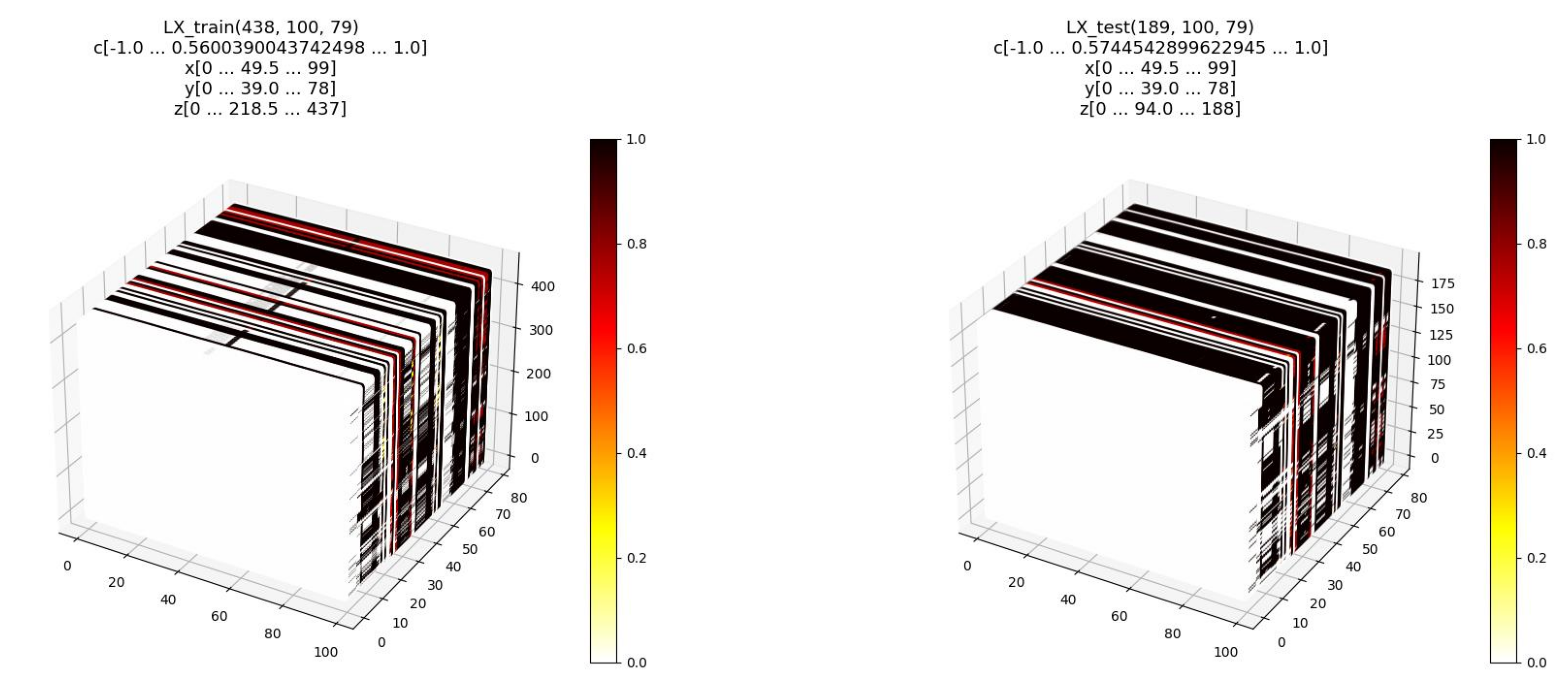

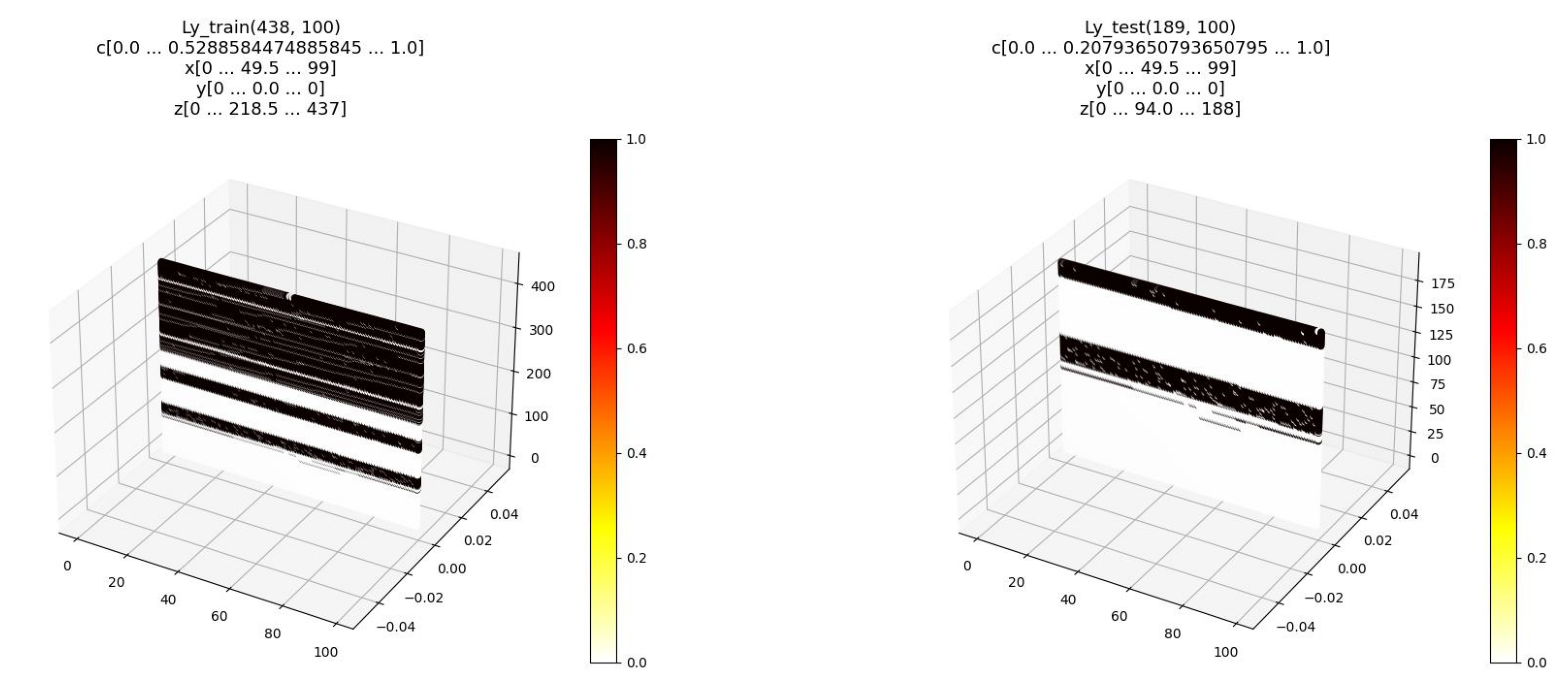

In [14]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_train','LX_test'])
show_4d_imgs(['Ly_train','Ly_test'])

# 4.INTRODUCTION

To create powerful models, especially for solving Seq2Seq learning problems, LSTM is the key layer.
To use LSTM effectively in models, we need to understand how it generates different results with respect to given parameters.

## 4.1.QUICK RECAP OF LSTM

### 4.1.1.Internal Structure

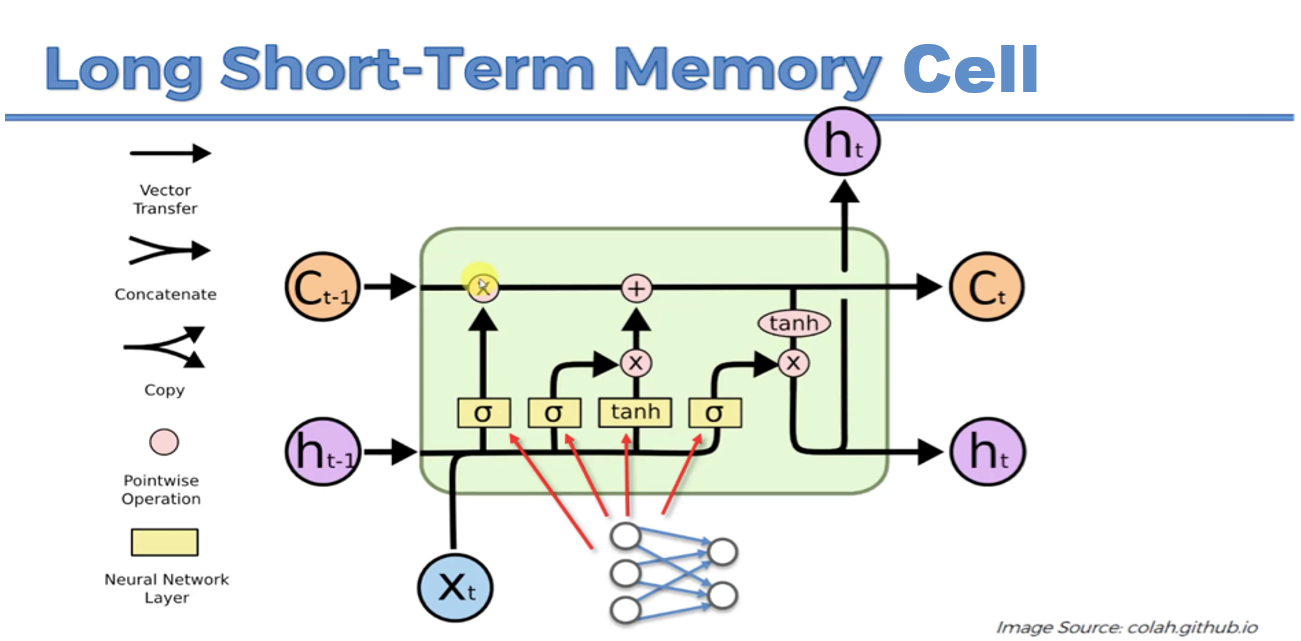

### 4.1.2.Roll-Out Representation of LSTM for each Time Step

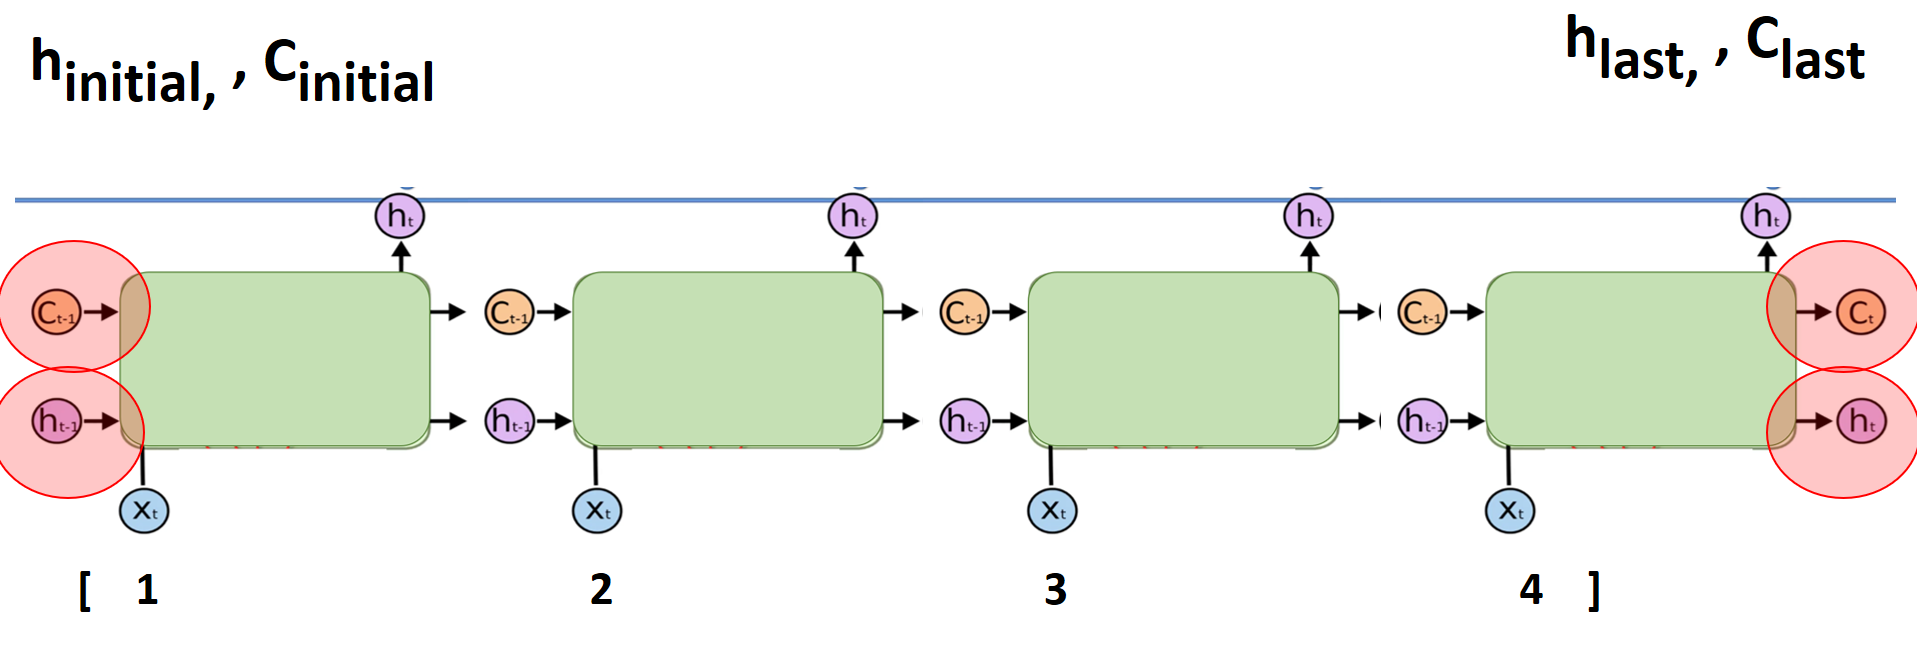

# 5.Train function

In [15]:
#@title train function

def train(model, name='model6'):
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  history = model.fit(LX_train, Ly_train, batch_size=batch_size, epochs=epochs, validation_data=(LX_test, Ly_test))
  show_train_metric(history, name)
  model.save(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
  open(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}/features.json", "w").write(json.dumps(features))

In [16]:
#@title infer function
def threshold(num):
    return 1 if num > 0.5 else 0

def infer_by_checkpoint(checkpoint, name='model6'):
  model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
  ##############LX_train
  L_result1=model.predict(LX_train)
  train_predicted = np.vectorize(threshold)(L_result1)
  print(f"Ly_train_predicted/Ly_train = {train_predicted.sum()}/{Ly_train.sum()}")

  ##############LX_test
  L_result2=model.predict(LX_test)
  test_predicted = np.vectorize(threshold)(L_result2)
  print(f"Ly_test_predicted/Ly_test = {test_predicted.sum()}/{Ly_test.sum()}")

  IMG['Ly_train_predicted'], IMG['Ly_test_predicted'] = ray.get([
    show_scattered_4d.remote(L_result1, "Ly_train_predicted"),
    show_scattered_4d.remote(L_result2, "Ly_test_predicted"),
  ])
  show_4d_imgs(['LX_train','Ly_train','Ly_train_predicted'])
  show_4d_imgs(['LX_test','Ly_test','Ly_test_predicted'])


___

# 6.LSTM Anomaly model (Primary)

## 6.1.Model layers



In [17]:
def new_model6():
  num_outputs = 10
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  #state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  #state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  #tf.nn.sigmoid
  dense1 = tf.keras.layers.Dense(hidden_size, activation=None, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      #initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model6: Model = Model(
      inputs=input_layer,
      #[
      #  input_layer, #seq_in,
      #  state_in_h,
      #  state_in_c
      #],
      outputs=values
      #[
      #  logits,
      #  values,
      #  state_h,
      #  state_c
      #]
      )
  return model6

model6 = new_model6()
model6.summary()

2023-02-20 16:19:51.188595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-20 16:19:51.189344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-20 16:19:51.190091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-02-20 16:19:51.190853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 79)]        0         
                                                                 
 dense1 (Dense)              (None, None, 230)         18400     
                                                                 
 lstm (LSTM)                 [(None, None, 320),       705280    
                              (None, 320),                       
                              (None, 320)]                       
                                                                 
 values (Dense)              (None, None, 1)           321       
                                                                 
Total params: 724,001
Trainable params: 724,001
Non-trainable params: 0
_________________________________________________________________


## 6.2.Train



Epoch 1/120


2023-02-20 16:19:54.213374: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-20 16:19:55.223209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


14/14 [==============================] - 5s 58ms/step - loss: 0.4991 - accuracy: 0.7695 - val_loss: 0.2801 - val_accuracy: 0.7946
Epoch 2/120
14/14 [==============================] - 0s 19ms/step - loss: 0.2088 - accuracy: 0.9212 - val_loss: 0.1128 - val_accuracy: 0.9601
Epoch 3/120
14/14 [==============================] - 0s 20ms/step - loss: 0.1238 - accuracy: 0.9618 - val_loss: 0.0986 - val_accuracy: 0.9693
Epoch 4/120
14/14 [==============================] - 0s 19ms/step - loss: 0.1132 - accuracy: 0.9632 - val_loss: 0.0773 - val_accuracy: 0.9783
Epoch 5/120
14/14 [==============================] - 0s 19ms/step - loss: 0.0966 - accuracy: 0.9708 - val_loss: 0.0739 - val_accuracy: 0.9784
Epoch 6/120
14/14 [==============================] - 0s 19ms/step - loss: 0.0860 - accuracy: 0.9738 - val_loss: 0.0764 - val_accuracy: 0.9759
Epoch 7/120
14/14 [==============================] - 0s 19ms/step - loss: 0.0834 - accuracy: 0.9737 - val_loss: 0.0644 - val_accuracy: 0.9799
Epoch 8/120
14/14 

2023-02-20 16:20:29.866272: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


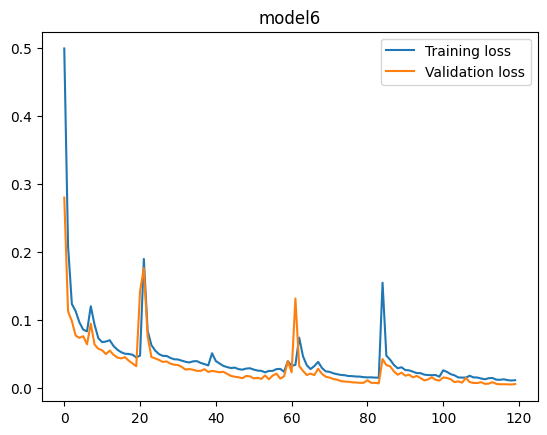

In [18]:
train(model6)

## 6.3.Infer



Ly_train_predicted/Ly_train = 23286/23164.0
Ly_test_predicted/Ly_test = 3958/3930.0


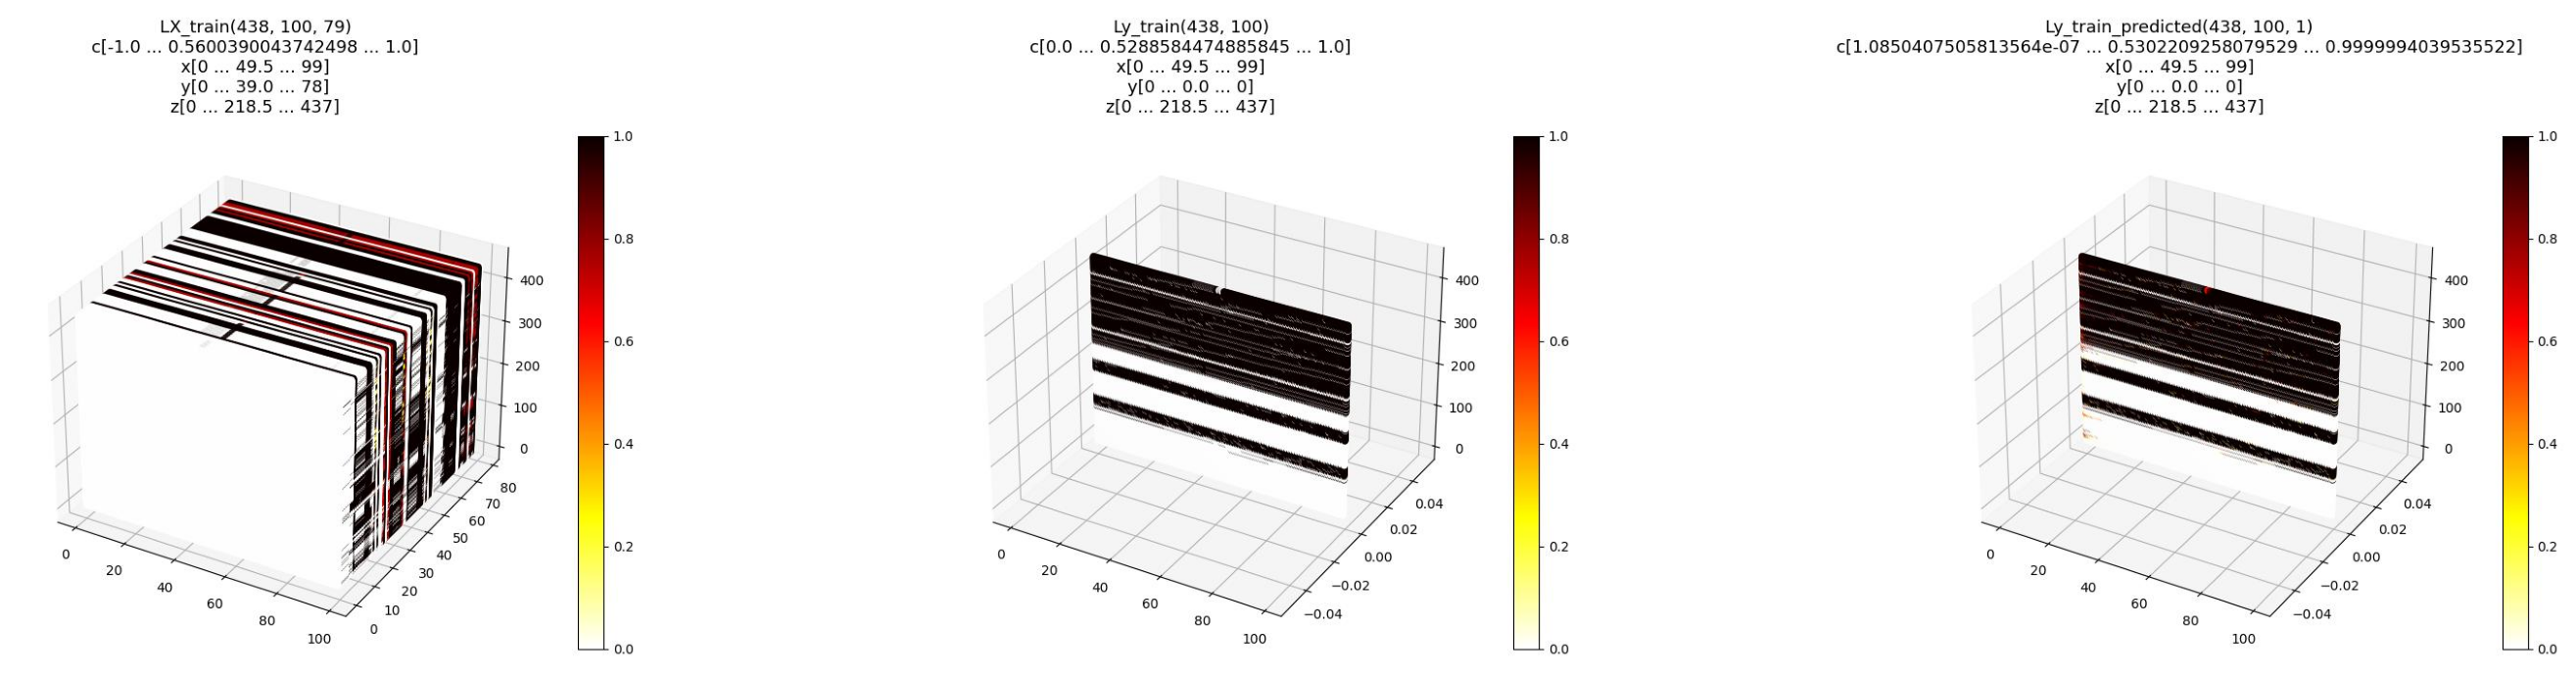

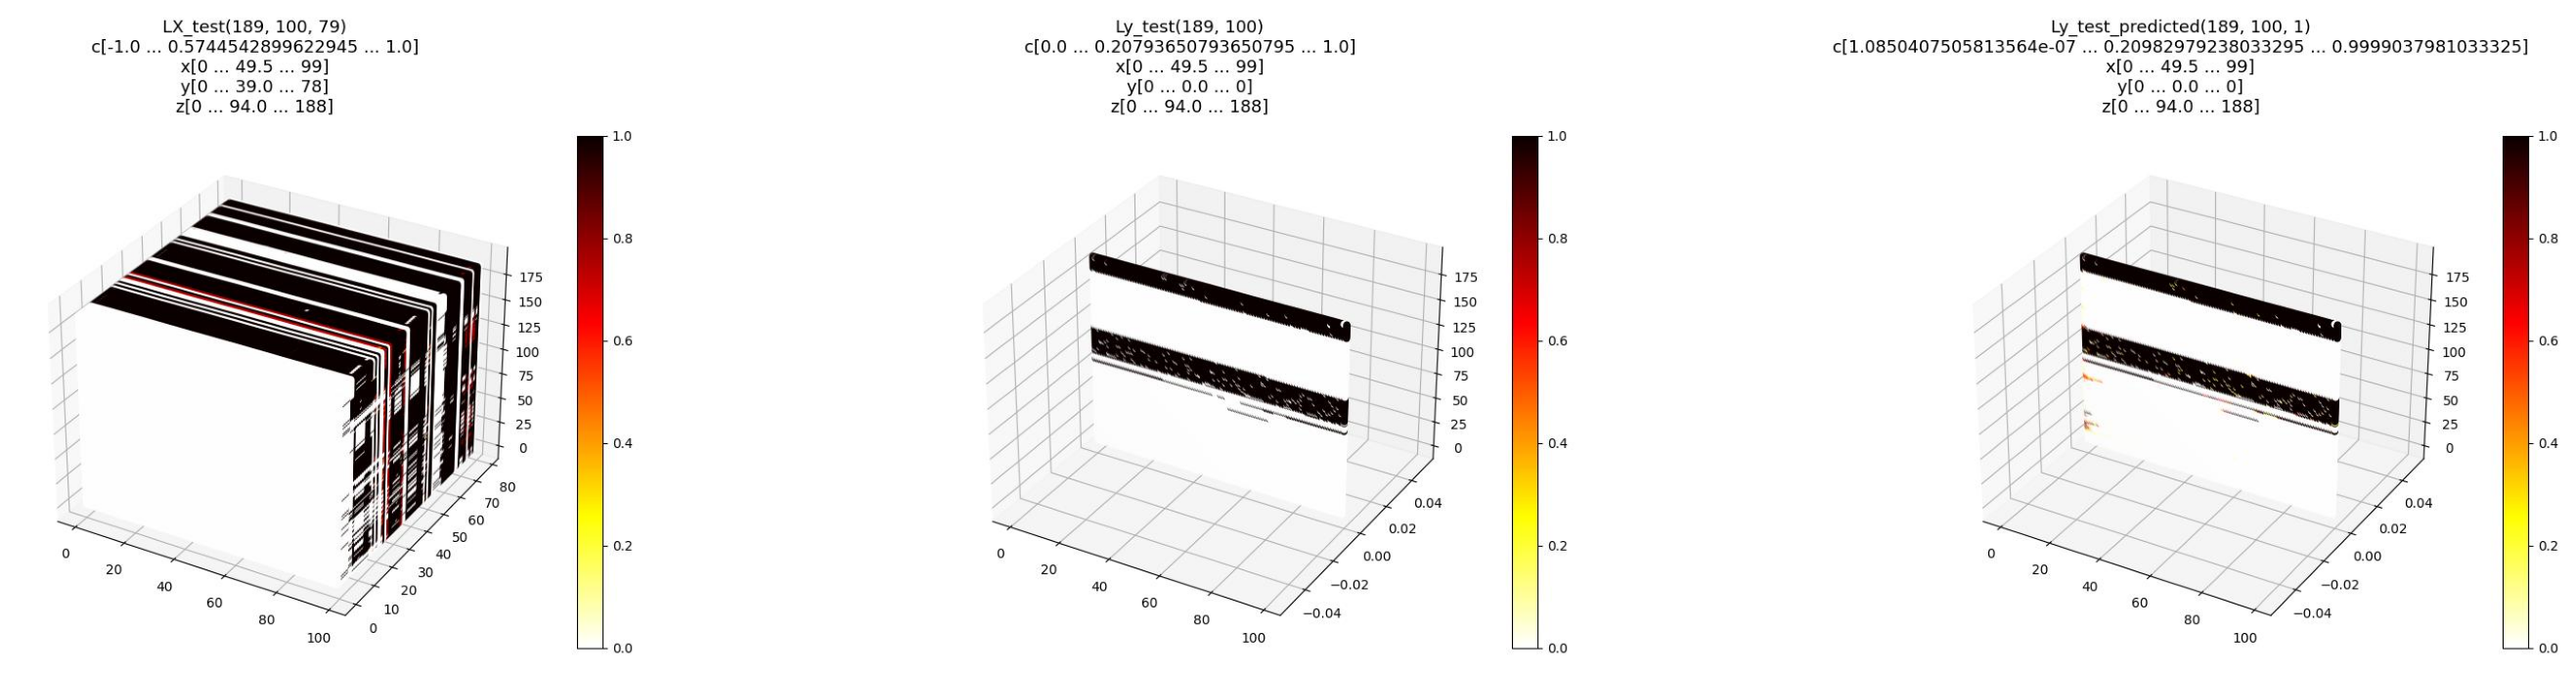

In [19]:
infer_by_checkpoint(checkpoint)

# 7.MODEL WEIGHTS SUMMARY

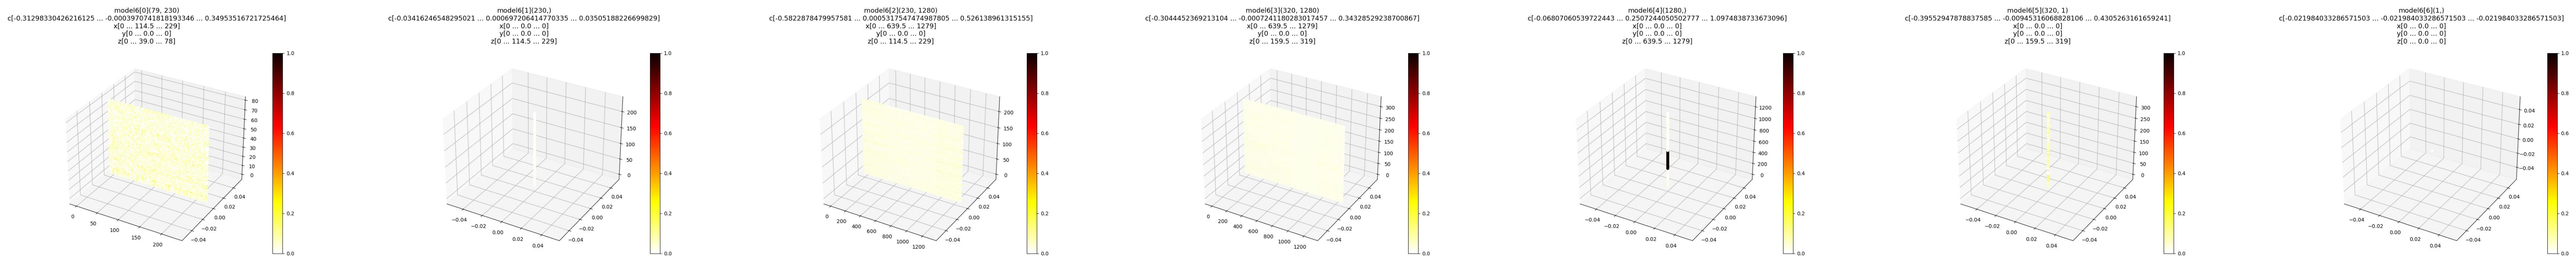

In [20]:
weights6 = show_weights(model6, 'model6')
show_4d_imgs(weights6)